In [58]:
# !pip install tensorflow
import tensorflow as tf

Creating helper function to print random images

In [59]:
def plot_random_image(directory_path,
                       target_class,
                       no_of_images=4,
                       ):
    '''
    Helper function that plots selected number of images from chosen directory path

    :param directory_path: type string, for ex './train/'
    :param target_class: type string, for ex. 'hot_dog'
    :param no_of_images: type int, number of images to show
    :return:
    '''
    import random
    import os
    import matplotlib.pyplot as plt
    from PIL import Image

    x = random.sample(os.listdir(directory_path + '/' + target_class), no_of_images)

    # Create plotting grid
    fig, axes = plt.subplots(1, no_of_images, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(int(15 + no_of_images * 2))

    # plot selected images and their shapes
    for i in range(no_of_images):
        img = directory_path + '/' + target_class + '/' + x[i]

        axes[i].imshow(Image.open(img), cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'{target_class}  Img shape:{plt.imread(img).shape}')

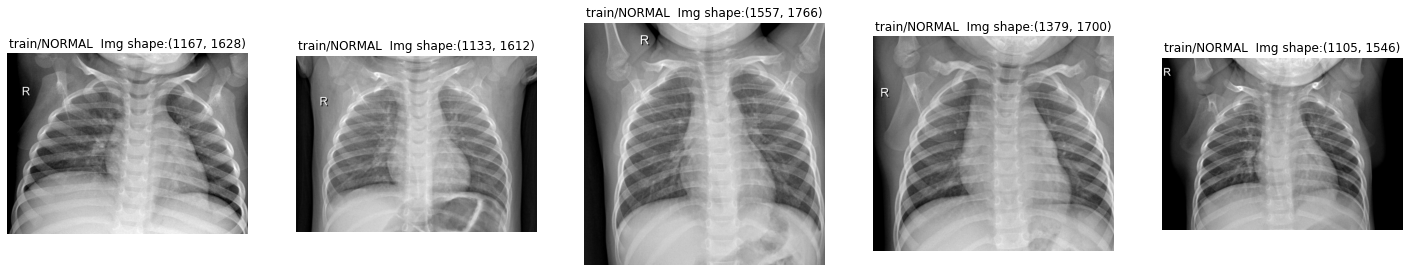

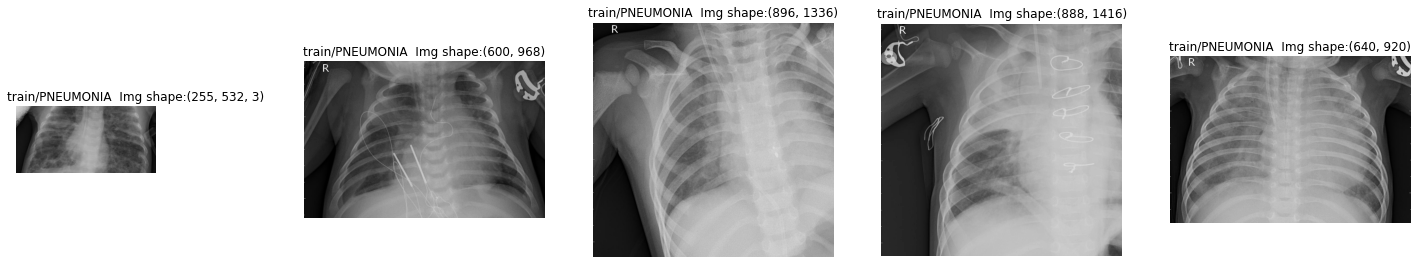

In [60]:
directory_path='/content/drive/MyDrive/Colab Notebooks/chest_xray'

plot_random_image(directory_path,'train/NORMAL',no_of_images=5)
plot_random_image(directory_path,'train/PNEUMONIA',no_of_images=5)

Creating image loaders

In [61]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=0.2,
                                                                  width_shift_range=.2,
                                                                  shear_range=0.2,
                                                                  vertical_flip=True,
                                                                  height_shift_range =.2
                                                                  )

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
                                                                  )


IMG_SIZE = (224,224)


In [62]:
train_loader = train_image_generator.flow_from_directory(directory=directory_path+'/train',
                                                   target_size = IMG_SIZE,
                                                   batch_size = 32,
                                                   shuffle = True,
                                                   class_mode = 'binary')

validation_loader = image_generator.flow_from_directory(directory = directory_path+'/val',
                                                        target_size=IMG_SIZE,
                                                        shuffle=True,
                                                        class_mode = 'binary',
                                                        batch_size = 32)

test_loader = image_generator.flow_from_directory(directory= directory_path+'/test',
                                                  target_size = IMG_SIZE,
                                                  class_mode = 'binary',
                                                  batch_size = 32)

builder_shape = next(train_loader)[0].shape
print(builder_shape)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
(32, 224, 224, 3)


In [63]:
import tensorflow_hub as hub

First Model = Efficient Net B0 

In [64]:
#input layer
inputs = tf.keras.layers.Input((224,224,3))

#model
model = hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b0/classification/1")(inputs)
model.trainable = False

#flatten / GlobalAvgPool2D
# x = tf.keras.layers.AveragePooling2D()(model)

#output layer
outputs = tf.keras.layers.Dense(1,activation='sigmoid')(model)

#callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='/content/drive/MyDrive/Colab Notebooks/chest_xray/tensorboard_logs')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/chest_xray/checkpoints',save_best_only=True)
finish_training = tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)

#model as a whole
model_1 = tf.keras.Model(inputs,outputs)

model_1.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='binary_crossentropy',
                metrics=['accuracy'],
                )

model_1.build(builder_shape)

model_1.summary()


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 keras_layer_8 (KerasLayer)  (None, 1000)              5330564   
                                                                 
 dense_8 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 5,331,565
Trainable params: 1,001
Non-trainable params: 5,330,564
_________________________________________________________________


In [65]:
train_steps = len(train_loader)
valid_steps = len(validation_loader)
history_1 = model_1.fit(train_loader,
                        steps_per_epoch = train_steps,
                        
                        validation_data = validation_loader,
                        validation_steps= valid_steps,
                        epochs = 10,
                        callbacks = [tensorboard_callback,checkpoint_callback,finish_training]
                        
                        )

Epoch 1/10
163/163 [==============================] - ETA: 0s - loss: 0.6694 - accuracy: 0.7003INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/chest_xray/checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/chest_xray/checkpoints/assets


163/163 [==============================] - 137s 788ms/step - loss: 0.6694 - accuracy: 0.7003 - val_loss: 0.6986 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 111s 681ms/step - loss: 0.6322 - accuracy: 0.7429 - val_loss: 0.7109 - val_accuracy: 0.5000
Epoch 3/10
163/163 [==============================] - 112s 684ms/step - loss: 0.6056 - accuracy: 0.7429 - val_loss: 0.7299 - val_accuracy: 0.5000
Epoch 4/10
163/163 [==============================] - 111s 682ms/step - loss: 0.5858 - accuracy: 0.7429 - val_loss: 0.7498 - val_accuracy: 0.5000
Epoch 5/10
163/163 [==============================] - 110s 675ms/step - loss: 0.5732 - accuracy: 0.7429 - val_loss: 0.7689 - val_accuracy: 0.5000
Epoch 6/10
163/163 [==============================] - 111s 682ms/step - loss: 0.5643 - accuracy: 0.7429 - val_loss: 0.7876 - val_accuracy: 0.5000


Second Model = ResNet50vs made for image classification

In [66]:
#input layer
inputs = tf.keras.layers.Input((224,224,3))

#model
model = hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5")(inputs)
model.trainable = False

#flatten / GlobalAvgPool2D
# x = tf.keras.layers.AveragePooling2D()(model)

#output layer
outputs = tf.keras.layers.Dense(1,activation='sigmoid')(model)

#callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='/content/drive/MyDrive/Colab Notebooks/chest_xray/tensorboard_logs')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/chest_xray/checkpoints',save_best_only=True)
finish_training = tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)

#model as a whole
model_2 = tf.keras.Model(inputs,outputs)

model_2.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='binary_crossentropy',
                metrics=['accuracy'],
                )

model_2.build(builder_shape)

model_2.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 keras_layer_9 (KerasLayer)  (None, 1001)              25615849  
                                                                 
 dense_9 (Dense)             (None, 1)                 1002      
                                                                 
Total params: 25,616,851
Trainable params: 1,002
Non-trainable params: 25,615,849
_________________________________________________________________


In [67]:
train_steps = len(train_loader)
valid_steps = len(validation_loader)
history_2 = model_2.fit(train_loader,
                        steps_per_epoch = train_steps,
                        
                        validation_data = validation_loader,
                        validation_steps= valid_steps,
                        epochs = 10,
                        callbacks = [tensorboard_callback,checkpoint_callback,finish_training]
                        
                        )

Epoch 1/10
163/163 [==============================] - ETA: 0s - loss: 7.5192 - accuracy: 0.7987INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/chest_xray/checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/chest_xray/checkpoints/assets


163/163 [==============================] - 121s 719ms/step - loss: 7.5192 - accuracy: 0.7987 - val_loss: 4.2808 - val_accuracy: 0.7500
Epoch 2/10
163/163 [==============================] - ETA: 0s - loss: 3.5200 - accuracy: 0.8152INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/chest_xray/checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/chest_xray/checkpoints/assets


163/163 [==============================] - 118s 723ms/step - loss: 3.5200 - accuracy: 0.8152 - val_loss: 3.6564 - val_accuracy: 0.7500
Epoch 3/10
163/163 [==============================] - 111s 680ms/step - loss: 2.8260 - accuracy: 0.8393 - val_loss: 9.6945 - val_accuracy: 0.6250
Epoch 4/10
163/163 [==============================] - 110s 674ms/step - loss: 2.5974 - accuracy: 0.8414 - val_loss: 14.1216 - val_accuracy: 0.5625
Epoch 5/10
163/163 [==============================] - 110s 676ms/step - loss: 3.2609 - accuracy: 0.8342 - val_loss: 7.3384 - val_accuracy: 0.6875
Epoch 6/10
163/163 [==============================] - 110s 674ms/step - loss: 3.0459 - accuracy: 0.8533 - val_loss: 15.3614 - val_accuracy: 0.5625
Epoch 7/10
163/163 [==============================] - 110s 674ms/step - loss: 3.0093 - accuracy: 0.8528 - val_loss: 12.4493 - val_accuracy: 0.5625


Third Model = ResNet50vs made for feature extraction

In [68]:
#input layer
inputs = tf.keras.layers.Input((224,224,3))

#model
model = hub.KerasLayer("https://tfhub.dev/sayakpaul/distill_bit_r50x1_224_feature_extraction/1")(inputs)
model.trainable = False

#flatten / GlobalAvgPool2D
# x = tf.keras.layers.AveragePooling2D()(model)

#output layer
outputs = tf.keras.layers.Dense(1,activation='sigmoid')(model)

#callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='/content/drive/MyDrive/Colab Notebooks/chest_xray/tensorboard_logs')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/chest_xray/checkpoints',save_best_only=True)
finish_training = tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)

#model as a whole
model_3 = tf.keras.Model(inputs,outputs)

model_3.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='binary_crossentropy',
                metrics=['accuracy'],
                )

model_3.build(builder_shape)

model_3.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 keras_layer_10 (KerasLayer)  (None, 2048)             23500352  
                                                                 
 dense_10 (Dense)            (None, 1)                 2049      
                                                                 
Total params: 23,502,401
Trainable params: 2,049
Non-trainable params: 23,500,352
_________________________________________________________________


In [69]:
train_steps = len(train_loader)
valid_steps = len(validation_loader)
history_3 = model_3.fit(train_loader,
                        steps_per_epoch = train_steps,
                        
                        validation_data = validation_loader,
                        validation_steps= valid_steps,
                        epochs = 10,
                        callbacks = [tensorboard_callback,checkpoint_callback,finish_training]
                        
                        )

Epoch 1/10
163/163 [==============================] - ETA: 0s - loss: 0.3347 - accuracy: 0.8608

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/chest_xray/checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/chest_xray/checkpoints/assets


163/163 [==============================] - 145s 802ms/step - loss: 0.3347 - accuracy: 0.8608 - val_loss: 0.4207 - val_accuracy: 0.8125
Epoch 2/10
163/163 [==============================] - 116s 713ms/step - loss: 0.2182 - accuracy: 0.9270 - val_loss: 0.4531 - val_accuracy: 0.7500
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.1849 - accuracy: 0.9358

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/chest_xray/checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/chest_xray/checkpoints/assets


163/163 [==============================] - 131s 801ms/step - loss: 0.1849 - accuracy: 0.9358 - val_loss: 0.3915 - val_accuracy: 0.8125
Epoch 4/10
163/163 [==============================] - ETA: 0s - loss: 0.1685 - accuracy: 0.9383

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/chest_xray/checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/chest_xray/checkpoints/assets


163/163 [==============================] - 129s 792ms/step - loss: 0.1685 - accuracy: 0.9383 - val_loss: 0.3012 - val_accuracy: 0.8125
Epoch 5/10
163/163 [==============================] - 118s 721ms/step - loss: 0.1525 - accuracy: 0.9438 - val_loss: 0.3330 - val_accuracy: 0.8125
Epoch 6/10
163/163 [==============================] - 117s 716ms/step - loss: 0.1432 - accuracy: 0.9515 - val_loss: 0.3426 - val_accuracy: 0.8125
Epoch 7/10
163/163 [==============================] - ETA: 0s - loss: 0.1407 - accuracy: 0.9502

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/chest_xray/checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/chest_xray/checkpoints/assets


163/163 [==============================] - 129s 788ms/step - loss: 0.1407 - accuracy: 0.9502 - val_loss: 0.2557 - val_accuracy: 0.8750
Epoch 8/10
163/163 [==============================] - 117s 715ms/step - loss: 0.1274 - accuracy: 0.9553 - val_loss: 0.2833 - val_accuracy: 0.8125
Epoch 9/10
163/163 [==============================] - 116s 710ms/step - loss: 0.1282 - accuracy: 0.9538 - val_loss: 0.3785 - val_accuracy: 0.8125
Epoch 10/10
163/163 [==============================] - 116s 714ms/step - loss: 0.1240 - accuracy: 0.9578 - val_loss: 0.3056 - val_accuracy: 0.8125


Helper Function which will visually help with comparing trained models

In [70]:

def plot_training_history(history_list=[] ,figsize=(7 ,15) ,metrics_to_show=['accuracy' ,'val_accuracy' ,'loss' ,'val_loss']):
    '''
    Helper function that plots metrics shown in metrics_to_show variable

    :param history: history object from Tensorflow.keras
    :param figsize: total size of a plotting grid
    :param metrics_to_show: do not add any more metrics
    :return: two plots containing training and validation metrics
    '''
    import matplotlib.pyplot as plt


    # Create plotting grid
    fig, axes = plt.subplots(1, 2, sharex=True, sharey=False)
    fig.set_figheight(figsize[0])
    fig.set_figwidth(figsize[1])

    # Create objects to plot
    epochs = range(1 ,len(history_list[0].history['loss'] ) +1)
    for i,history in enumerate(history_list):
      # Plot metrics
      if 'loss' in metrics_to_show:
          loss = history.history['loss']
          axes[0].plot(epochs ,loss ,label=f'train loss model {i+1}')
          axes[0].legend(loc='upper left')

      if 'val_loss' in metrics_to_show:
          val_loss = history.history['val_loss']
          axes[0].plot(epochs ,val_loss ,label=f'validation loss model {i+1}')
          axes[0].legend(loc='upper left')

      if 'accuracy' in metrics_to_show:
          accuracy = history.history['accuracy']
          axes[1].plot(epochs ,accuracy ,label=f'train accuracy model {i+1}')
          axes[1].legend(loc='upper left')

      if 'val_accuracy' in metrics_to_show:
          val_accuracy = history.history['val_accuracy']
          axes[1].plot(epochs ,val_accuracy ,label=f'validation accuracy model {i+1}')
          axes[1].legend(loc='upper left')

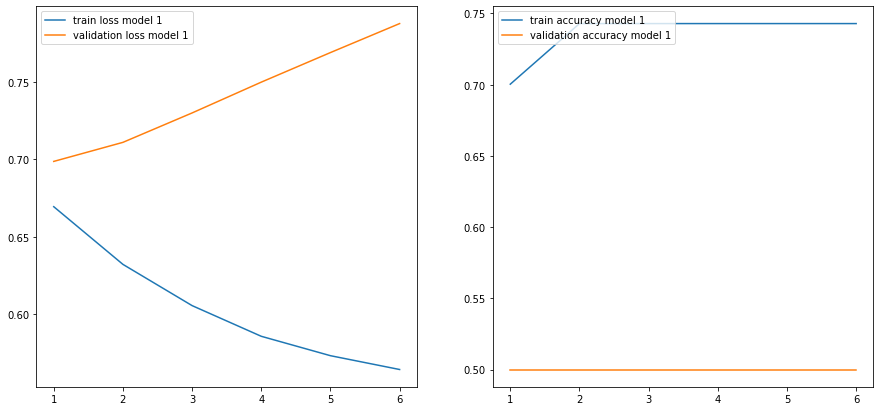

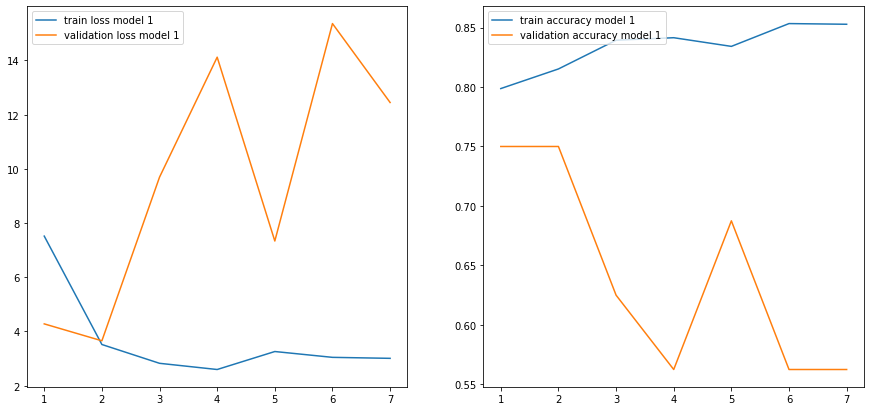

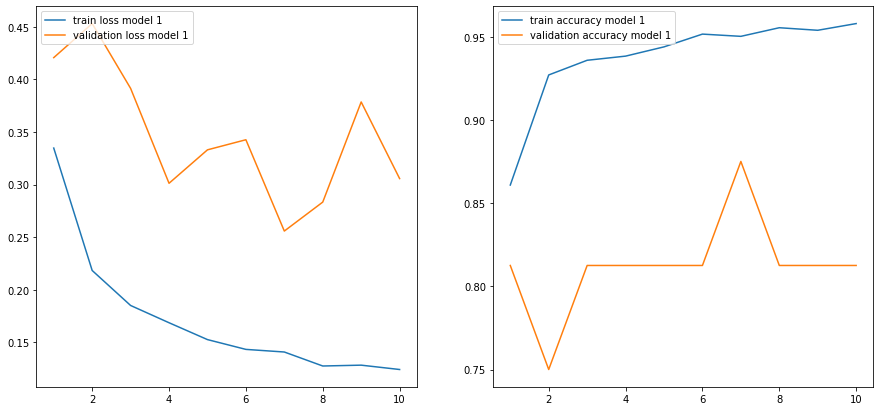

In [73]:
plot_training_history([history_1])
plot_training_history([history_2])
plot_training_history([history_3])

Evaluation on unseen data


In [74]:
model_3.evaluate(test_loader)

20/20 [==============================] - 7s 359ms/step - loss: 0.4145 - accuracy: 0.8045


[0.4144890010356903, 0.8044871687889099]

In [75]:
model_2.evaluate(test_loader)

20/20 [==============================] - 7s 334ms/step - loss: 5.0008 - accuracy: 0.7420


[5.000809669494629, 0.7419871687889099]

In [76]:
model_1.evaluate(test_loader)

20/20 [==============================] - 7s 338ms/step - loss: 0.6691 - accuracy: 0.6250


[0.6691436767578125, 0.625]

Summary: Best model with least loss and highest accuracy was model no. 3 which is ResNet50vs made for feature extraction